In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
from brisc.manuscript_analysis import viral_library as virlib

import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42  # for pdfs

import flexiznam as flz

In [ ]:
# Placeholder
# TODO: setup flexilims project
project = "barcode_diversity_analysis"
flexilims_session = flz.get_flexilims_session(project)
READ_ROOT = (
    flz.get_data_root("processed", flexilims_session=flexilims_session)
    / "rabies_manuscript_figures"
)
SAVE_ROOT = (
    flz.get_data_root("processed", flexilims_session=flexilims_session)
    / "rabies_manuscript_figures"
)
SAVE_ROOT.mkdir(parents=True, exist_ok=True)
reload = False

Preparing log barcode counts for plasmid: /nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/PBC20/PBC20_bowtie_ed1.txt
Preparing log barcode counts for virus: /nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/RV35/RV35_bowtie_ed2.txt
Preparing log barcode counts for virus: /nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/RV31/RV31_bowtie_ed2.txt
Preparing log barcode counts for virus: /nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/RV32/RV32_bowtie_ed2.txt
Preparing log barcode counts for virus: /nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/RV35/RV35_bowtie_ed2.txt
Preparing uniquely labeled plot for virus: /nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/RV31/RV31_bowtie_ed2.txt
Preparing uniquely labeled plot for virus: /nemo/lab/znamenskiyp/home

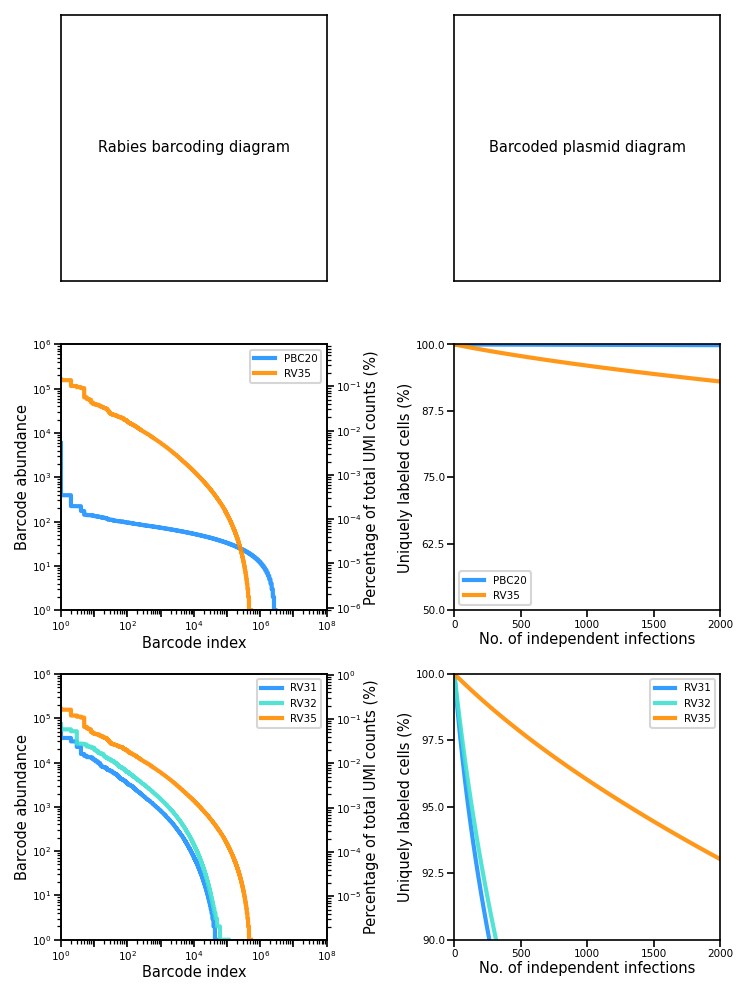

In [23]:
# Plot Fig.1
fontsize_dict = {"title": 7, "label": 7, "tick": 5, "legend": 5}
pad_dict = {"label": 1, "tick": 1, "legend": 5}
line_width = 2
line_alpha = 0.9

cm = 1 / 2.54
fig = plt.figure(figsize=(18 * cm, 18 * cm), dpi=150)
data_path = Path(
    "/nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/collapsed_barcodes/"
)
save_path = Path(
    "/nemo/lab/znamenskiyp/home/shared/projects/barcode_diversity_analysis/figures/"
)
save_fig = False
figname = "fig1_plasmid_barcoding_schema_library"

# Coord format: [left, bottom, width, height]
ax_locations = [
    [0.05, 0.67, 0.25, 0.25],  # Top-left
    [0.42, 0.67, 0.25, 0.25],  # Top-right
    [0.05, 0.36, 0.25, 0.25],  # Middle-left
    [0.42, 0.36, 0.25, 0.25],  # Middle-right
    [0.05, 0.05, 0.25, 0.25],  # Bottom-left
    [0.42, 0.05, 0.25, 0.25],  # Bottom-right
]

# Add blank squares with text
ax_rv_bc_diagram = fig.add_axes(ax_locations[0])
ax_rv_bc_diagram.text(
    0.5,
    0.5,
    "Rabies barcoding diagram",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=fontsize_dict["title"],
)
ax_rv_bc_diagram.set_xticks([])
ax_rv_bc_diagram.set_yticks([])

ax_plasmid_diagram = fig.add_axes(ax_locations[1])
ax_plasmid_diagram.text(
    0.5,
    0.5,
    "Barcoded plasmid diagram",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=fontsize_dict["title"],
)
ax_plasmid_diagram.set_xticks([])
ax_plasmid_diagram.set_yticks([])

# 1) Plot the plasmid and virus abundance histograms
ax_abundance = fig.add_axes(ax_locations[2])
im = virlib.plot_barcode_counts_and_percentage(
    data_path=data_path,
    virus_to_plot=["RV35"],
    virus_ed="2",
    virus_collapse="bowtie",
    plasmid_to_plot=["PBC20"],
    plasmid_ed="1",
    plasmid_collapse="bowtie",
    verbose=True,
    label_fontsize=fontsize_dict["label"],
    label_pad=pad_dict["label"],
    tick_fontsize=fontsize_dict["tick"],
    tick_pad=pad_dict["tick"],
    line_alpha=line_alpha,
    line_width=line_width,
    colors=[
        "darkorange",
        "dodgerblue",
    ],
    ax=ax_abundance,
)

# 2) Plot the plasmid and virus histograms
ax_unique = fig.add_axes(ax_locations[3])
im = virlib.plot_unique_label_fraction(
    data_path=data_path,
    virus_to_plot=["RV35"],
    virus_ed="2",
    virus_collapse="bowtie",
    plasmid_to_plot=["PBC20"],
    plasmid_ed="1",
    plasmid_collapse="bowtie",
    stride=50,
    max_cells=2000,
    min_max_percent_unique_range=(0.5, 1.0),
    verbose=False,
    label_fontsize=fontsize_dict["label"],
    label_pad=pad_dict["label"],
    tick_fontsize=fontsize_dict["tick"],
    tick_pad=pad_dict["tick"],
    line_alpha=line_alpha,
    line_width=line_width,
    colors=[
        "darkorange",
        "dodgerblue",
    ],
    ax=ax_unique,
)

# 3) Plot the virus rescue scaling abundance histograms
ax_scaling = fig.add_axes(ax_locations[4])
im = virlib.plot_barcode_counts_and_percentage(
    data_path=data_path,
    virus_to_plot=["RV31", "RV32", "RV35"],
    virus_ed="2",
    virus_collapse="bowtie",
    plasmid_to_plot=[],
    plasmid_ed="1",
    plasmid_collapse="bowtie",
    verbose=True,
    label_fontsize=fontsize_dict["label"],
    label_pad=pad_dict["label"],
    tick_fontsize=fontsize_dict["tick"],
    tick_pad=pad_dict["tick"],
    line_alpha=line_alpha,
    line_width=line_width,
    colors=[
        "dodgerblue",
        "turquoise",
        "darkorange",
        "green",
    ],
    ax=ax_scaling,
)

ax_scaling_unique = fig.add_axes(ax_locations[5])
im = virlib.plot_unique_label_fraction(
    data_path=data_path,
    virus_to_plot=["RV31", "RV32", "RV35"],
    virus_ed="2",
    virus_collapse="bowtie",
    plasmid_to_plot=[],
    plasmid_ed="1",
    plasmid_collapse="bowtie",
    stride=100,
    max_cells=2000,
    min_max_percent_unique_range=(0.9, 1.0),
    verbose=True,
    label_fontsize=fontsize_dict["label"],
    label_pad=pad_dict["label"],
    tick_fontsize=fontsize_dict["tick"],
    tick_pad=pad_dict["tick"],
    line_alpha=line_alpha,
    line_width=line_width,
    colors=[
        "dodgerblue",
        "turquoise",
        "darkorange",
        "green",
    ],
    ax=ax_scaling_unique,
)


if save_fig:
    pdf_path = f"{save_path}/figures/{figname}.pdf"
    png_path = f"{save_path}/figures/{figname}.png"
    fig.savefig(pdf_path, format="pdf", transparent=True, bbox_inches="tight")
    fig.savefig(png_path, format="png", transparent=True, bbox_inches="tight")
    print(f"Saved PDF figure to {pdf_path}")
    print(f"Saved PNG figure to {png_path}")